Enter the number of nodes: 5
Degree Sequence: [2, 2, 3, 4, 3]


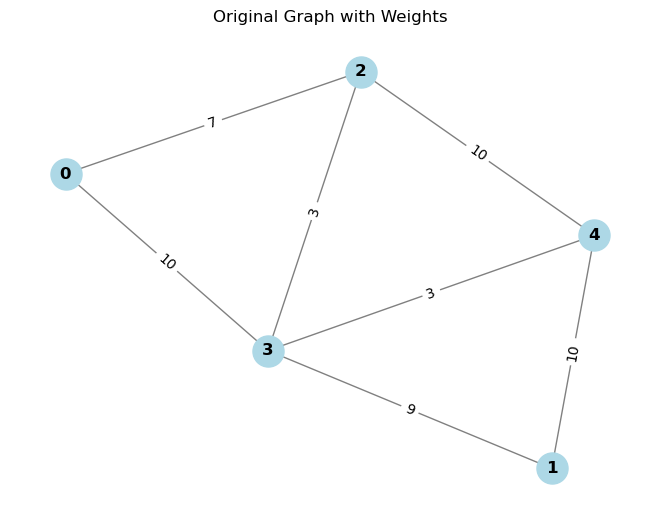

Minimum Spanning Tree (MST) edges: [(0, 2, {'weight': 7}), (2, 3, {'weight': 3}), (3, 4, {'weight': 3}), (3, 1, {'weight': 9})]


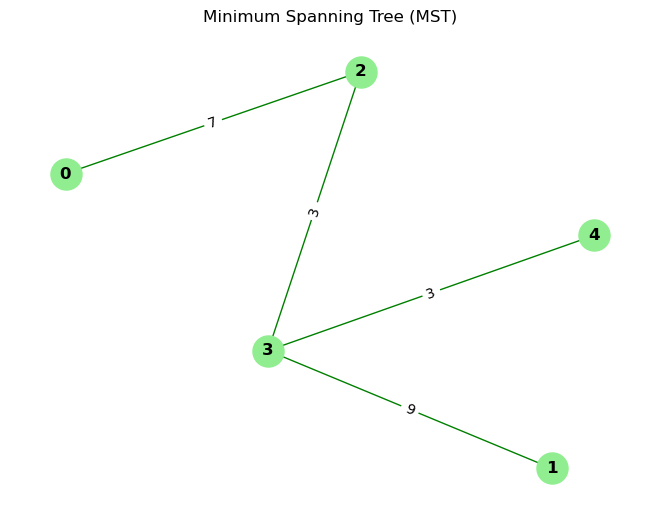

Enter the source node (0 to 4): 2
Shortest path distances from node 2 using Bellman-Ford: {0: 7, 1: 12, 2: 0, 3: 3, 4: 6}
Eulerian Status: Eulerian Path
Eulerian Path/Circuit: [4, 3, 2, 4, 1, 3, 0, 2]
Fundamental Cutsets: [((0, 2), [(0, 3), (0, 2)]), ((2, 3), [(0, 3), (2, 3), (2, 4)]), ((3, 4), [(1, 4), (2, 4), (3, 4)]), ((3, 1), [(1, 3), (1, 4)])]
Fundamental Circuits: [[(0, 2), (2, 3), (3, 0)], [(3, 4), (4, 1), (1, 3)], [(2, 3), (3, 4), (4, 2)]]
Edge Connectivity: 2, Vertex Connectivity: 2, K-Connectivity: 2
Cut Vertices: []


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import heapq

def havel_hakimi(deg_seq):
    while True:
        deg_seq.sort(reverse=True)
        if deg_seq[0] == 0: 
            return True
        d = deg_seq.pop(0)  
        if d > len(deg_seq):
            return False
        for i in range(d):
            deg_seq[i] -= 1 
            if deg_seq[i] < 0:
                return False


def generate_graphic_sequence(n):
    while True:
        deg_seq = [random.randint(1, n-1) for _ in range(n)]
        if havel_hakimi(deg_seq[:]):
            return deg_seq


def construct_connected_graph(deg_seq):
    G = nx.Graph()
    G.add_nodes_from(range(len(deg_seq)))

    degree_list = [(deg_seq[i], i) for i in range(len(deg_seq))]

    while degree_list:
        degree_list.sort(reverse=True, key=lambda x: x[0])
        d, node = degree_list.pop(0)

        if d > len(degree_list): 
            raise ValueError("Degree sequence is not graphical!")

        for i in range(d):
            neighbor_deg, neighbor = degree_list[i]
            G.add_edge(node, neighbor)
            degree_list[i] = (neighbor_deg - 1, neighbor)

        degree_list = [pair for pair in degree_list if pair[0] > 0]

    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            
            G.add_edge(random.choice(list(components[i-1])), random.choice(list(components[i])))

    return G


def prim_mst(G):
    mst = nx.Graph()
    start_node = list(G.nodes)[0] 
    visited = set([start_node])
    edges = [(G[start_node][to]['weight'], start_node, to) for to in G.neighbors(start_node)]
    heapq.heapify(edges)  
    
    while edges:
        weight, frm, to = heapq.heappop(edges)
        if to not in visited:
            visited.add(to)
            mst.add_edge(frm, to, weight=weight)

            for neighbor in G.neighbors(to):
                if neighbor not in visited:
                    heapq.heappush(edges, (G[to][neighbor]['weight'], to, neighbor))
    
    return mst


def assign_random_weights(G):
    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)


def bellman_ford(G, source):
    distances = {node: float('inf') for node in G.nodes}
    distances[source] = 0

    for _ in range(len(G.nodes) - 1):
        for u, v, data in G.edges(data=True):
            weight = data['weight']
            if distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
            if distances[v] + weight < distances[u]:  
                distances[u] = distances[v] + weight

    
    for u, v, data in G.edges(data=True):
        weight = data['weight']
        if distances[u] + weight < distances[v] or distances[v] + weight < distances[u]:
            print("Graph contains a negative-weight cycle")
            return None

    return distances


def fleury_algorithm(G):
    
    status = is_eulerian(G)
    if status == "Not Eulerian":
        print("The graph is not Eulerian.")
        return None

    
    odd_degree_nodes = [node for node, degree in G.degree() if degree % 2 != 0]
    start_node = odd_degree_nodes[0] if odd_degree_nodes else list(G.nodes)[0]

    eulerian_trail = []
    current_path = [start_node]

    while current_path:
        u = current_path[-1]

        if G.degree(u) == 0:
            eulerian_trail.append(u)
            current_path.pop()
        else:
            for v in list(G.neighbors(u)):
                G.remove_edge(u, v)
                current_path.append(v)
                break

    return eulerian_trail


def is_eulerian(G):
    odd_degree_nodes = [node for node, degree in G.degree() if degree % 2 != 0]
    if len(odd_degree_nodes) == 0 and nx.is_connected(G):
        return "Eulerian Circuit"
    elif len(odd_degree_nodes) == 2 and nx.is_connected(G):
        return "Eulerian Path"
    else:
        return "Not Eulerian"


def find_fundamental_cutsets(G, mst):
    cutsets = []
    for edge in mst.edges():
        mst.remove_edge(*edge)  
        components = list(nx.connected_components(mst))  
        cutset = []
        
        for u, v in G.edges():
            
            if (u in components[0] and v in components[1]) or (u in components[1] and v in components[0]):
                cutset.append((u, v))
        
        cutsets.append((edge, cutset))  
        mst.add_edge(*edge) 

    return cutsets


def find_fundamental_circuits(G, mst):
    circuits = []
    for u, v in G.edges():
        if not mst.has_edge(u, v): 
            mst.add_edge(u, v)  
            cycle = list(nx.find_cycle(mst))  
            circuits.append(cycle)
            mst.remove_edge(u, v) 

    return circuits


def calculate_connectivities(G):
    edge_conn = nx.edge_connectivity(G)  
    vertex_conn = nx.node_connectivity(G)
    k_connected = vertex_conn  
    return edge_conn, vertex_conn, k_connected

def find_cut_vertices(G):
    return list(nx.articulation_points(G))


def main():
    n = int(input("Enter the number of nodes: "))  
    deg_seq = generate_graphic_sequence(n)
    print("Degree Sequence:", deg_seq)
    G = construct_connected_graph(deg_seq)
    assign_random_weights(G)
    pos = nx.spring_layout(G)  
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, font_weight='bold', edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Original Graph with Weights")
    plt.show()
    mst = prim_mst(G)
    print("Minimum Spanning Tree (MST) edges:", mst.edges(data=True))
    mst_edge_labels = nx.get_edge_attributes(mst, 'weight')
    nx.draw(mst, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=12, font_weight='bold', edge_color='green')
    nx.draw_networkx_edge_labels(mst, pos, edge_labels=mst_edge_labels)
    plt.title("Minimum Spanning Tree (MST)")
    plt.show()
    source = int(input(f"Enter the source node (0 to {n-1}): "))
    distances = bellman_ford(G, source)
    if distances is not None:
        print("Shortest path distances from node", source, "using Bellman-Ford:", distances)
    status = is_eulerian(G)
    print("Eulerian Status:", status)
    
    if status != "Not Eulerian":
        eulerian_trail = fleury_algorithm(G.copy()) 
        if eulerian_trail:
            print("Eulerian Path/Circuit:", eulerian_trail)
    cutsets = find_fundamental_cutsets(G, mst)
    print("Fundamental Cutsets:", cutsets)

    circuits = find_fundamental_circuits(G, mst)
    print("Fundamental Circuits:", circuits)

    edge_conn, vertex_conn, k_connected = calculate_connectivities(G)
    print(f"Edge Connectivity: {edge_conn}, Vertex Connectivity: {vertex_conn}, K-Connectivity: {k_connected}")

    cut_vertices = find_cut_vertices(G)
    print("Cut Vertices:", cut_vertices)

main()
